In [73]:
#필요한 모듈들을 모두 import합니다.
from rank_bm25 import BM25Okapi
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import json


In [78]:
#코드 동작에 필요한 필수적인 변수들을 담는 class입니다.
class args:
    DATA_PATH = "../data"
    DOCUMENT_NAME = "DOC_NQ_first64.tsv"
    QUERY_TRAIN_NAME = "GTQ_NQ_train.tsv"
    QUERY_DEV_NAME = "GTQ_NQ_dev.tsv"
    TOPK = 1000
    SHORT_INFERENCE = True #시간 관계상 모든 dev query를 inferece하지 않고, 100개만 inference하는 경우 사용합니다
    SAVE_PATH = "../data/inference"
    PRED_SAVE_NAME = "BM25_Baseline.json"
    METRIC_SAVE_NAME = "BM25_Result.json"

In [49]:
#사용할 데이터들을 로드한 뒤 간단한 정보를 확인합니다.
document_corpus = pd.read_csv(f"{args.DATA_PATH}/{args.DOCUMENT_NAME}", sep="\t", dtype=str)
query_train_corpus = pd.read_csv(f"{args.DATA_PATH}/{args.QUERY_TRAIN_NAME}", sep="\t", dtype=str)
query_dev_corpus = pd.read_csv(f"{args.DATA_PATH}/{args.QUERY_DEV_NAME}", sep="\t", dtype=str)

print(f"# of Document : {len(document_corpus)}")
print(f"# of Train Query : {len(query_train_corpus)}")
print(f"# of Dev Query : {len(query_dev_corpus)}")

print("\n","="*40)
print(document_corpus.info())

print("\n","="*40)
print(document_corpus.head(5))

# of Document : 109696
# of Train Query : 307373
# of Dev Query : 7830

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109696 entries, 0 to 109695
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   oldid   109696 non-null  object
 1   query   109696 non-null  object
dtypes: object(2)
memory usage: 1.7+ MB
None

  oldid                                              query
0     0  email marketing  Email marketing is the act of...
1     1  the mother ( how i met your mother )  Tracy Mc...
2     2  human fertilization  Human fertilization is th...
3     3  list of national football league career quarte...
4     4  roanoke colony  The Roanoke Colony ( / ˈroʊəˌn...


In [50]:
#간단한 전처리를 진행합니다. 이후, 편의를 위해 Dict(key:oldid, value:query) 형태로 변환합니다.
def clean_text(text):
        text = text.replace("\n", "")
        text = text.replace("``", "")
        text = text.replace('"', "")
        text = text.replace('\'', "")
        return text.lower().strip()

#apply clean text
document_corpus['query'] = document_corpus['query'].apply(clean_text)
query_train_corpus['query'] = query_train_corpus['query'].apply(clean_text)
query_dev_corpus['query'] = query_dev_corpus['query'].apply(clean_text)

#convert to dict
document_corpus = dict(zip(document_corpus["oldid"], document_corpus['query'])) 
query_train_corpus = dict(zip(query_train_corpus["oldid"], query_train_corpus['query'])) 
query_dev_corpus = dict(zip(query_dev_corpus["oldid"], query_dev_corpus['query'])) 

#convert index to document oldid
index2oldid = {index: oldid for index, oldid in enumerate(document_corpus.keys())}

for i, (k,v) in enumerate(document_corpus.items()):
        print(f"{k}, {v}")
        if (i==4):
                break

0, email marketing  email marketing is the act of sending a commercial message , typically to a group of people , using email . in its broadest sense , every email sent to a potential or current customer could be considered email marketing . it usually involves using email to send advertisements , request business , or solicit sales or donations , and is meant to build loyalty , trust , or brand awareness . marketing emails can be sent to a purchased lead list or a current customer database . the term usually refers to sending email messages with the purpose of enhancing a merchant s relationship with current or previous customers , encouraging customer loyalty and repeat business , acquiring new customers or convincing current customers to purchase something immediately , and sharing third - party ads .
1, the mother ( how i met your mother )  tracy mcconnell ( colloquial :  the mother  ) is the title character from the cbs television sitcom how i met your mother . the show , narrated

In [51]:
# BM25 방법을 사용하기 위해 corpus를 token 단위로 쪼갭니다.
# baseline이므로, tokenizer 사용 대신 word 단위로 쪼개는 과정을 사용하였습니다.
# 쪼갠 token을 이용하여 BM25를 학습합니다.

tokenized_corpus = [doc.split(" ") for doc in document_corpus.values()]
bm25 = BM25Okapi(tokenized_corpus)

In [52]:
#마찬가지로 train query 또한 token 단위로 쪼갠 뒤, BM25 검색을 수행하여 알맞은 문서가 검색되는지 확인합니다
#np.random으로 매번 임의의 query로 검색을 수행합니다.

#임의의 query 및 answer를 선정합니다
target = np.random.randint(0,100)
answer_docid, train_query = list(query_train_corpus.items())[target]
answer_document = document_corpus[answer_docid]

#query를 토큰화하여 bm25 score를 구합니다.
tokenized_query = train_query.split(" ")
query_document_scores = bm25.get_scores(tokenized_query)
query_document_ranking = np.argsort(query_document_scores)[::-1]

print(f"Query: {train_query}")
print(f"Answer DocID: {answer_docid}")
print(f"Answer Document: {answer_document}")
print("\n","="*40,"\n")

#검색 결과를 점수순으로 출력합니다
for idx in query_document_ranking[:5]:
    print(f"Document {index2oldid[idx]} - Score: {query_document_scores[idx]:.4f}")
    print(f"Document Contents: {document_corpus[index2oldid[idx]]}")
    print("\n","-"*40)

Query: who has the most wins as an nfl quarterback
Answer DocID: 3
Answer Document: list of national football league career quarterback wins leaders  the following is a list of the top national football league ( nfl ) quarterbacks in wins . in the nfl , the quarterback is the only position that is credited with records of wins and losses .


Document 3 - Score: 36.2434
Document Contents: list of national football league career quarterback wins leaders  the following is a list of the top national football league ( nfl ) quarterbacks in wins . in the nfl , the quarterback is the only position that is credited with records of wins and losses .

 ----------------------------------------
Document 80299 - Score: 28.6497
Document Contents: kellen moore  kellen moore ( born july 5 , 1988 ) is a former american football quarterback who is the quarterbacks coach of the dallas cowboys of the national football league ( nfl ) . he played six seasons in the nfl for the cowboys and detroit lions . he

In [63]:
#실제로 query dev set에 대하여 검색 결과를 top-1000개까지 생성한 뒤, 이를 저장합니다.
#저장 형태는 Dict[index: Tuple[정답 문서 list, 예측 문서 list]] 입니다.

result = dict()

for dev_index, (answer_docid, dev_query) in tqdm(enumerate(query_dev_corpus.items()), total=len(query_dev_corpus.items())):

    #마찬가지로 query를 토큰화하여 bm25 score를 구합니다.
    tokenized_query = dev_query.split(" ")
    query_document_scores = bm25.get_scores(tokenized_query)
    query_document_ranking = np.argsort(query_document_scores)[::-1]
    
    #ranking 결과 top1000개를 Dict(answer_docid:List(preds_docid)) 형태로 저장합니다
    preds_docid = [index2oldid[idx] for idx in query_document_ranking[:args.TOPK]]
    result[dev_index] = ([answer_docid], preds_docid) # Dict(int: Tuple[List,List]) 
    
    if args.SHORT_INFERENCE and dev_index==99:
        break

  1%|▏         | 99/6930 [00:46<53:54,  2.11it/s]  


In [64]:
#예측 결과를 확인합니다
for idx in range(10):
    print(list(result.items())[idx])

(0, (['1'], ['74779', '32415', '100085', '19530', '16189', '1', '85716', '19775', '20199', '13046', '59786', '1120', '47293', '37752', '8445', '104884', '61035', '79441', '61811', '10898', '14859', '452', '50435', '69442', '12921', '21831', '35449', '83193', '52022', '78108', '5626', '19546', '39358', '89809', '13062', '28914', '91146', '8403', '12458', '61204', '30729', '32187', '82564', '77246', '26508', '31408', '109368', '27681', '38658', '73278', '100710', '11380', '39750', '47935', '12264', '17145', '47083', '20600', '46742', '8576', '6108', '39994', '28213', '84409', '21305', '55305', '31289', '73716', '78313', '21207', '10563', '52257', '107024', '5760', '22126', '19087', '32031', '15022', '107144', '44539', '5471', '12280', '23456', '106780', '42623', '78622', '30054', '9378', '92723', '92678', '63175', '54902', '92528', '54632', '82336', '96449', '32513', '337', '92631', '33527', '33988', '89358', '11785', '83022', '75789', '42788', '19095', '53134', '8201', '70668', '48236',

In [65]:
#예측 성능을 시각화합니다. 여기서는 Recall 평가지표를 사용합니다.
def recall_at_k(relevant_docs, predicted_docs, k):
    relevant_set = set(relevant_docs)
    predicted_at_k = set(predicted_docs[:k])
    recall = len(relevant_set & predicted_at_k) / min(len(relevant_set),k)
    return recall

#Recall@K의 K값 리스트입니다.
k_values = [1, 5, 10, 50, 100, 200, 500, 1000]

results = {k: [] for k in k_values}

#각 query에 대해 recall값을 계산합니다.
for qid, (relevant, predicted) in tqdm(result.items()):
    for k in k_values:
        recall = recall_at_k(relevant, predicted, k)
        results[k].append(recall)

#K 단위로 예측한 recall 값을 평균합니다.
average_recall = {k: sum(recalls) / len(recalls) for k, recalls in results.items()}

100%|██████████| 100/100 [00:00<00:00, 6216.45it/s]


Recall@1: 0.2300
Recall@5: 0.5100
Recall@10: 0.5900
Recall@50: 0.7500
Recall@100: 0.8200
Recall@200: 0.8600
Recall@500: 0.8800
Recall@1000: 0.9100


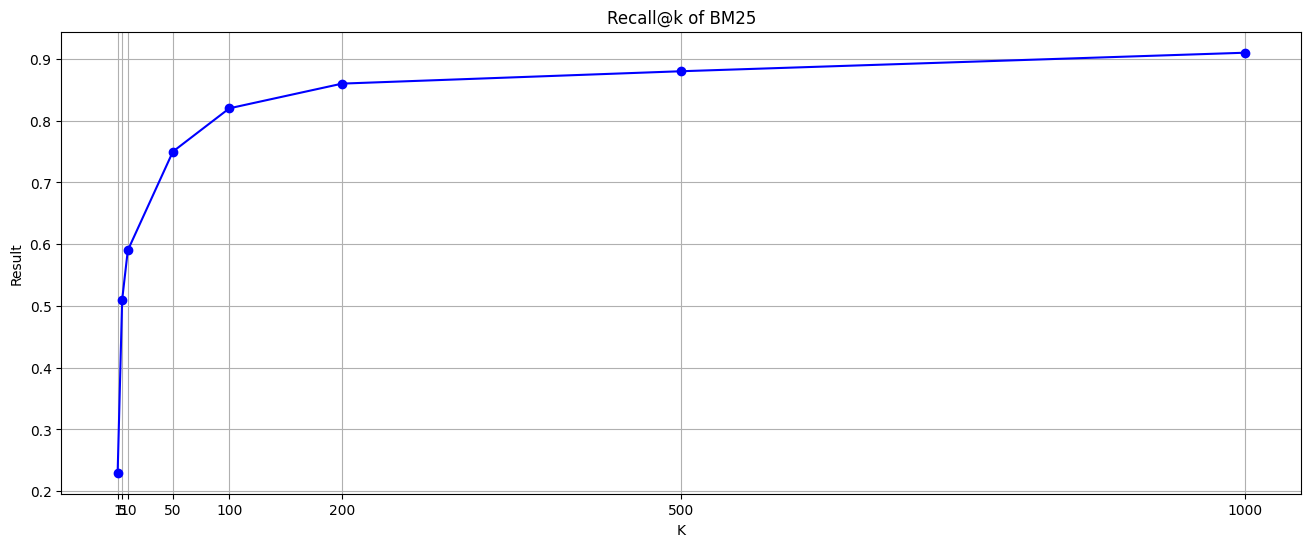

In [72]:
#결과 출력 및 시각화를 진행합니다.
for k, recall in average_recall.items():
    print(f"Recall@{k}: {recall:.4f}")

plt.figure(figsize=(16, 6))
plt.plot(list(average_recall.keys()), list(average_recall.values()), marker='o', linestyle='-', color='b')

plt.title('Recall@k of BM25')
plt.xlabel('K')
plt.ylabel('Result')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [79]:
#최종 결과를 저장합니다
with open(f"{args.SAVE_PATH}/{args.PRED_SAVE_NAME}", 'w') as f:
    json.dump(result, f)

with open(f"{args.SAVE_PATH}/{args.METRIC_SAVE_NAME}", 'w') as f:
    json.dump(average_recall, f)